# Logistic Regression


This notebook implements logistic regression, a supervised learning technique for binary classification. This regression algorithm estimates the probability that an instance belongs to a particular class. Specifically, given a set of input features, the logistic regression model produces an estimated probability of belonging to the *positive* class. If this estimated probability is at least 50%, then the instance is predicted to belong to this positive class; otherwise it is predicted to belong to the *negative* class.

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Import functions from scikit-learn to help with training/testing endeavors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## The Data

A logistic regression model will be trained using the [Hawks](https://r-data.pmagunia.com/dataset/r-dataset-package-stat2data-hawks) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

The code block below reads the dataset into a pandas DataFrame object, subsets the DataFrame to the relevant variables, and drops any rows where there are missing values for these relevant variables.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Wing", "Tail", "Weight", "Culmen", "Hallux"]].dropna(axis=0)
hawks

,Species,Wing,Tail,Weight,Culmen,Hallux
0,RT,385.0,219,920.0,25.7,30.1
2,RT,381.0,235,990.0,26.7,31.3
3,CH,265.0,220,470.0,18.7,23.5
4,SS,205.0,157,170.0,12.5,14.3
5,RT,412.0,230,1090.0,28.5,32.2
...,...,...,...,...,...,...
903,RT,380.0,224,1525.0,26.0,27.6
904,SS,190.0,150,175.0,12.7,15.4
905,RT,360.0,211,790.0,21.9,27.6
906,RT,369.0,207,860.0,25.2,28.0


### Preparing the data
Observe that the `Species` is a variable consisting of 3 categories:

1. `RT`: Red-tailed
2. `CH`: Cooper's
3. `SS`: Sharp-Shinned

Logistic regression is a binary classification method, so we will have to collapse these categories. From `hawks_analysis.ipynb` ([link](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb)), I observe that the Cooper's and sharp-shinned hawks are clustered relatively near each other.  Furthermore, there are disproportionate counts of each species in the dataset; there are far more red-tailed hawks. Therefore, I will combined the Cooper's and sharp-shinned hawks into a single "not red-tailed" group. The classification task will then be to identify if a hawk is red-tailed or not red-tailed, given it's wing length and tail length. As there is a clear clustering for each group based on their wing and tail lengths, classification is a viable goal. 

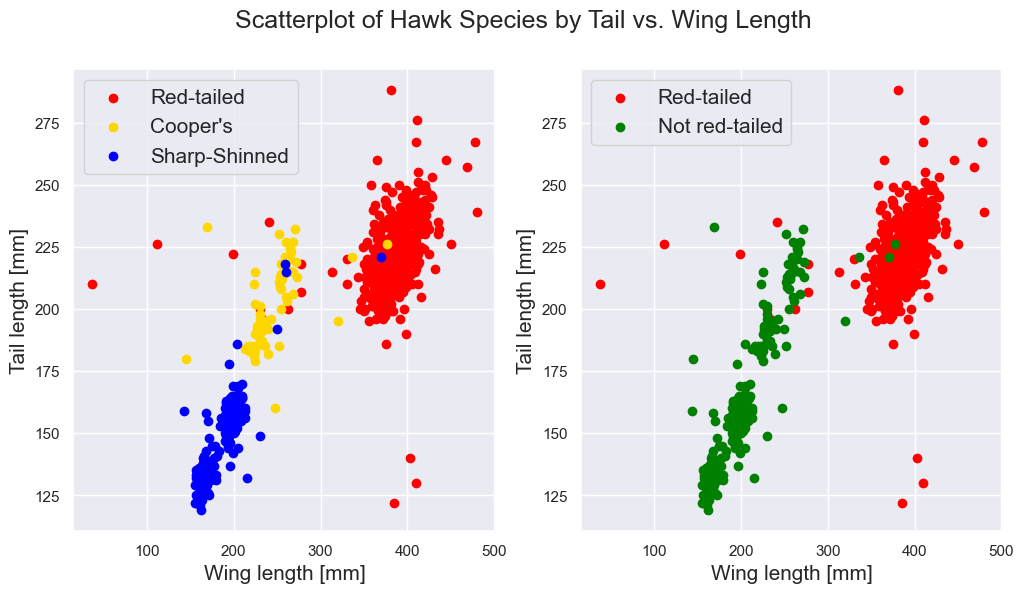

In [3]:
# Produce a scatterplot of tail vs. wing length, color-coded by hawk species
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle("Scatterplot of Hawk Species by Tail vs. Wing Length", fontsize = 18)
# First, plot the 3 different species' distribution on the left
RT = hawks[hawks.Species == "RT"]
CH = hawks[hawks.Species == "CH"]
SS = hawks[hawks.Species == "SS"]
ax1.scatter(RT.Wing, RT.Tail, color = "red", label = "Red-tailed")
ax1.scatter(CH.Wing, CH.Tail, color = "gold", label = "Cooper's")
ax1.scatter(SS.Wing, SS.Tail, color = "blue", label = "Sharp-Shinned")
ax1.set_xlabel("Wing length [mm]", fontsize = 15)
ax1.set_ylabel("Tail length [mm]", fontsize = 15)
ax1.legend(fontsize = 15, loc = "upper left")

# Plot the binary red-tailed vs. not red-tailed distribution on the right
NRT = hawks[hawks.Species != "RT"]
ax2.scatter(RT.Wing, RT.Tail, color = "red", label = "Red-tailed")
ax2.scatter(NRT.Wing, NRT.Tail, color = "green", label = "Not red-tailed")
ax2.set_xlabel("Wing length [mm]", fontsize = 15)
ax2.set_ylabel("Tail length [mm]", fontsize = 15)
ax2.legend(fontsize = 15, loc = "upper left")
plt.show()

Therefore when training the binary classification models, I will consolidate the 3 species down to two groups.

## Implementing the algorithm: a custom class

The class below contains methods that are useful to implementing logistic regression from scratch.

For details about the algorithm, check out the `README.md` in this directory.

In [4]:
class LogisticRegression(object):
    """
    A class to perform logistic regression.
    ...

    Attributes
    ----------
    weights_ : numpy.ndarray
        The weights and bias of the single neuron. The last entry being the bias. 
        This attribute is created when the train method is called.

    train_errors_: list
        A list containing error computed after each iteration of stochastic gradient descent.
 
    """

    def __init__(self):
        self.weights_ = None
        self.train_errors_ = []

    def train(self, X, y, rate = 0.005, iterations = 50):
        """
        Train a logistic regression model by iterating through the stochastic gradient descent 
        algorithm. This occurs for a total of "epochs" number of times with learning rate "rate".

        Parameters
        ----------
        X: matrix of feature values
        y: array of observed values
        rate (float): learning rate
        iterations (int): number of iterations to train the model for

        Returns: None
        """
        n_obs, n_features = X.shape
        self.train_errors_ = []

        # Initialize coefficients/weights and intercept/bias from a uniform distribution
        self.weights_ = np.random.rand(1 + n_features)
        
        # Implement stochastic gradient decent  
        for _ in range(iterations):
            errors = 0
            for xi, target in zip(X, y):
                error = (self.predict_prob(xi) - target)
                self.weights_[:-1] -= rate * error * xi
                self.weights_[-1] -= rate * error
                errors += self.entropy_loss(self.predict_prob(xi), target)
            self.train_errors_.append(errors / n_obs)

    def sigmoid(self, z):
        """
        Implements the sigmoid function, which maps pre-activation values to probabilities.
        This sigmoid function is used in the predict_prob method.
        """
        return 1 / (1 + np.exp(-z))
    
    def entropy_loss(self, y_hat, y):
        """
        Calculates the binary cross entropy loss for gradient descent.
        """
        return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)

    def predict_prob(self, X):
        """
        Use the weights and the feature vectors in X to make a prediction. This prediction
        is actually the probability that the observation belongs to the positive class. 
        """
        preactivation = np.dot(X, self.weights_[:-1]) + self.weights_[-1]
        return self.sigmoid(preactivation)

    def predict(self, X):
        """
        Given the feature vectors in X, make a prediction as to whether the observation
        belongs to the positive class or not.
        """
        return np.where(self.predict_prob(X) >= 0.5, 1, 0)

    def plot_cost_function(self):
        """
        Plot the binary cross entropy loss for each iteration of stochastic gradient descent.
        """
        plt.figure(figsize = (7, 5))
        plt.plot(range(1, len(self.train_errors_) + 1), self.train_errors_)
        plt.xlabel("Iterations")
        plt.ylabel("Entropy Loss")
        plt.title("Binary Cross Entropy Loss for Trained Logistic Regression Model")

    def plot_decision_boundary(self, X, y, x_title = "x", y_title = "y"):
        """
        Plot the decision boundary for the trained logistic regression model.
        """
        plt.figure(figsize = (7, 5))
        plot_decision_regions(X, y, clf = self)
        plt.title("Logistic Regression Decision Boundary", fontsize = 14)
        plt.xlabel(x_title, fontsize = 12)
        plt.ylabel(y_title, fontsize = 12)
        plt.show()

## Model 1: Binary Classification Using 1 Predictor (Tail Length)

First, I will perform logistic regression using only one feature. This is a good exercise to understand how logistic regression works. Observe from the left panel in the plot below that at lower tail lengths, it's more likely that a particular hawk is not red-tailed. At higher tail lengths, it's more likely that a hawk is red-tailed. Through the sigmoid function shown on the right, these tail lengths can be mapped to probabilities of observing one of these two groups.

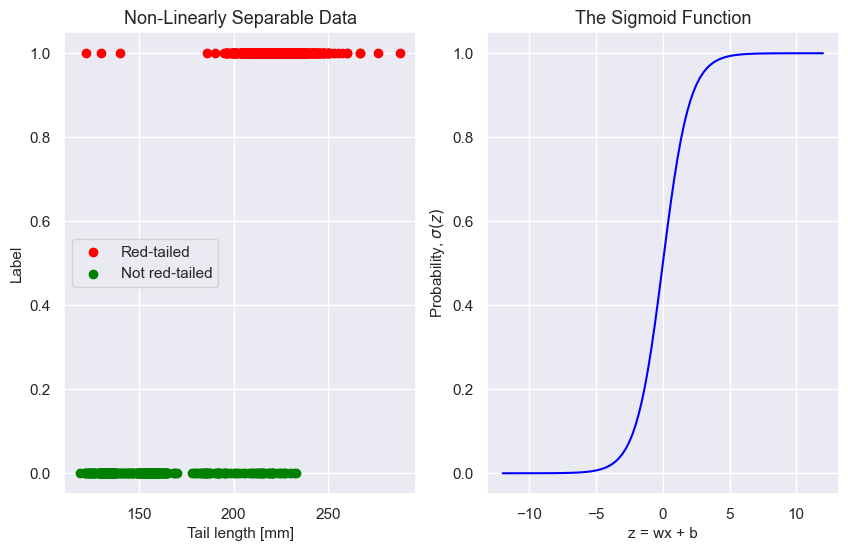

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
# Plot the binary red-tailed vs. not red-tailed distribution with respect to tail length only
ax1.scatter(RT.Tail, np.ones(len(RT.Tail)), color = "red", label = "Red-tailed")
ax1.scatter(NRT.Tail, np.zeros(len(NRT.Tail)), color = "green", label = "Not red-tailed")
ax1.set_xlabel("Tail length [mm]", fontsize = 11)
ax1.set_ylabel("Label", fontsize = 11)
ax1.set_title("Non-Linearly Separable Data", fontsize = 13)
ax1.legend(fontsize = 11, loc = "center left")

# Plot the sigmoid function for this example
domain = np.linspace(-12.0, 12.0, 100)
ax2.plot(domain, 1.0/(1.0 + np.exp(-domain)), color = "blue", label = "$\sigma$(z)")
ax2.set_xlabel("z = wx + b", fontsize = 11)
ax2.set_ylabel("Probability, $\sigma(z)$", fontsize = 11)
ax2.set_title("The Sigmoid Function", fontsize = 13)
plt.show()

Now, let's start training a logistic regression model!

The processed data is randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. The parameter `random_state=1` is used to ensure that we get the same observations in the training/testing set as in the Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb). We know from the plots in `hawks_analysis.ipynb` that the split using this `random_state` produces a training set that is a good representation for the data being tested (and vice versa).

In [6]:
# Set up predictors matrix (X) and response vector (y)
X = hawks[["Tail"]].to_numpy()
# Convert each entry of y with RT (red-tailed) to -1 and otherwise 1
hawks["Species_binary"] = [1 if x == "RT" else 0 for x in hawks.Species]
y = hawks["Species_binary"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [7]:
# Train the logistic regression model
lr_model = LogisticRegression()
lr_model.train(X_train, y_train, 0.0001, 5000)

/var/folders/vw/11tt08k53x3ftj1j70zwt66c0000gn/T/ipykernel_3503/688124607.py:62: RuntimeWarning: divide by zero encountered in log
  return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)
/var/folders/vw/11tt08k53x3ftj1j70zwt66c0000gn/T/ipykernel_3503/688124607.py:62: RuntimeWarning: invalid value encountered in multiply
  return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)


The "RuntimeWarning: divide by zero encountered in log" error is possible due to a predicted probability being very close to 0 or 1, which causes the logarithm to approach NaN (not a number). The "RuntimeWarning: invalid value encountered in multiply" error occurs for the same reason.

To prevent these errors, I could standardize or normalize the features to a more appropriate range. This doesn't always solve the issue, however. Interpretation wise, it could also change the importance of certain features, which in turn affects the predicted probability.

In [8]:
# Obtain model weights
lr_model.weights_

array([  0.0618687 , -11.00958227])

The weight associated with the tail predictor is listed first, followed by the weight for the bias. In terms of interpretation, in logistic regression, the coefficients represent the change in the log odds of the response variable for a one-unit change in the corresponding predictor variable, while holding all other predictors constant. These log odds can then be exponentiated to get the odds ratio. For example, the coefficient for tail length here is 0.06, the odds of being a red-tail hawk increases by a factor of $e^{0.06}=1.06$ with an increase in tail length by 1 mm.

For the bias/intercept term, this represents the log odds of the target variable when all predictor variables are zero. Here, it means that the odds of being a red-tailed hawk when tail length is 0 mm is $e^{-11.01}=0.00$, which makes sense when we refer back to the plot of the sigmoid function above.

### Performance/error analysis for model 1

Now, I will examine the performance of the model. Firstly, I look at the error plot from training the logistic regression model.

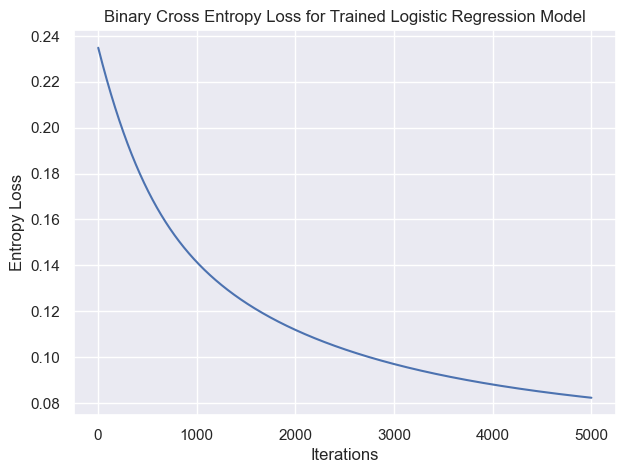

In [9]:
lr_model.plot_cost_function()
plt.show()

At first, the error was high, but by the 5000th iteration, it has been greatly minimized and begun to plateau. We can understand the performance of this model in the classification context by looking at the training and testing accuracy.

In [10]:
# Obtain predictions for training set and find the error of the model
y_train_pred = lr_model.predict(X_train)
print("Training accuracy:", sum(y_train == y_train_pred) / len(y_train))

Training accuracy: 0.9143258426966292


In [11]:
# Obtain predictions for testing set and find the test accuracy
y_test_pred = lr_model.predict(X_test)
print("Testing accuracy:", sum(y_test == y_test_pred) / len(y_test))

Testing accuracy: 0.9217877094972067


Training accuracy is around 91%, while the testing accuracy is 92%. This binary classification model is not bad, but it could do better. Based on the classification report for the testing data below, precision and recall could be improved as well.

In [12]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89        73
           1       0.88      1.00      0.94       106

    accuracy                           0.92       179
   macro avg       0.94      0.90      0.92       179
weighted avg       0.93      0.92      0.92       179



By the interpretation of precision, out of all the people in the testing set that the model predicted was a red-tailed hawk, only 88% actually were. By the interpretation of recall, out of all the people in the testing set that actually were not a red-tailed hawk, the model predicted this outcome correctly for 81% of these hawks.

We can understand this more in detail by looking at the confusion matrix for the model predictions.

In [13]:
def plot_RT_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    classes = [1, 0] # want to invert the order of the classes in outputted matrix
    # Obtain confusion matrix
    cf_matrix = confusion_matrix(y_actual, y_pred, labels=[1, 0])

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Hawk Species Classification Confusion Matrix\n', fontsize = 14)
    ax.set_xlabel('\nPredicted Values', fontsize = 12)
    ax.set_ylabel('Actual Values ', fontsize = 12)
    ax.xaxis.set_ticklabels(["RT", "Not RT"])
    ax.yaxis.set_ticklabels(["RT", "Not RT"])

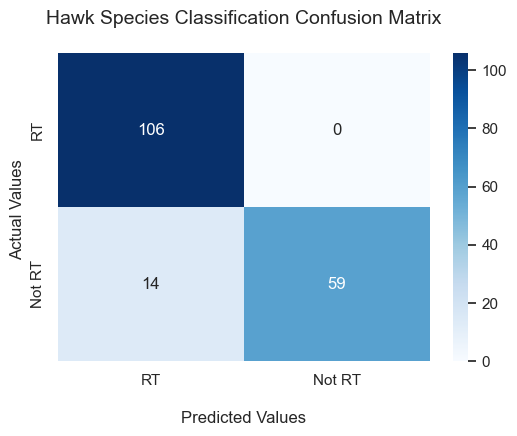

In [14]:
plot_RT_confusion_matrix(y_test, y_test_pred)
plt.show()

The misclassifications in this logistic regression model are all in the lower left corner. 14 non red-tailed hawks are being classified as red-tailed hawks. To understand why this is occurring, we can look at the decision regions for this logistic regression model. 

First, let's look at the probability curves (based on the sigmoid function) for each species with regard to tail length.

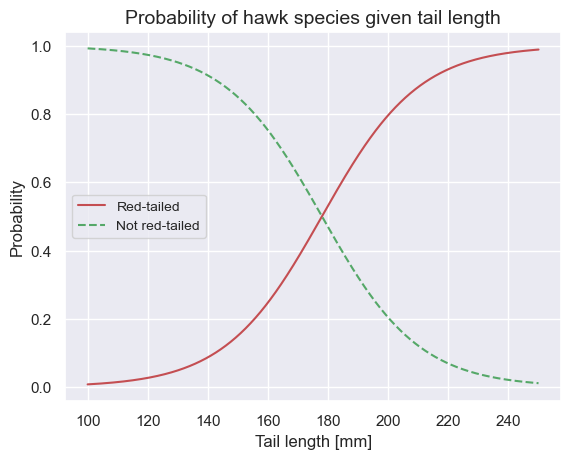

In [15]:
# Plot estimated probabilities to find decision boundary
X_new = np.linspace(100, 250, 1000).reshape(-1, 1)
y_prob = lr_model.predict_prob(X_new)
plt.plot(X_new, y_prob, "r-", label="Red-tailed") 
plt.plot(X_new, 1 - y_prob, "g--", label="Not red-tailed")
plt.legend(fontsize = 10, loc = "center left")
plt.xlabel("Tail length [mm]", fontsize = 12)
plt.ylabel("Probability", fontsize = 12)
plt.title("Probability of hawk species given tail length", fontsize = 14)
plt.show()

The two curves cross around 178 mm. This means that when a hawk has a tail length of at least 178 mm, it will be classified as a red-tailed hawk, while if it has a tail length that's less than 178 mm, it will be classified as a non red-tailed hawk. The decision region plot below confirms this finding.

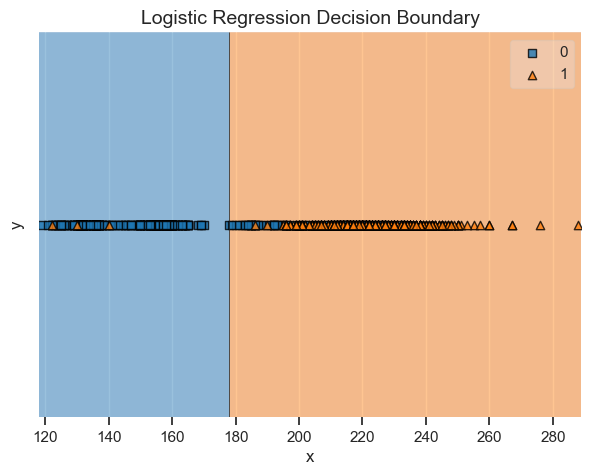

In [16]:
lr_model.plot_decision_boundary(X, y)

By visual inspection, this binary classifier could be doing better. The decision boundary could be shifted rightwards, as there are blue (not red-tailed hawk) observations that fall in the orange (red-tailed hawk) region. This results in the misclassifications discussed above.

To try and do better, let's fit a new logistic regression model, adding in a 2nd predictor.

## Model 2: Binary Classification Using 2 Predictors (Wing & Tail Length)

In the "Preparing the data" section, I showed a plot of hawk tail length vs. wing length, color-coded by hawk species/group. I'm optimistic that using these two predictors in the logistic regression model will lead to better performance compared to single feature model 1.

In [17]:
# Set up predictors matrix (X) and response vector (y)
X2 = hawks[["Wing", "Tail"]].to_numpy()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.20, random_state=1)

In [18]:
# Train the logistic regression model
lr_model2 = LogisticRegression()
lr_model2.train(X_train2, y_train2, 0.0001, 5000)

/var/folders/vw/11tt08k53x3ftj1j70zwt66c0000gn/T/ipykernel_3503/688124607.py:62: RuntimeWarning: divide by zero encountered in log
  return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)
/var/folders/vw/11tt08k53x3ftj1j70zwt66c0000gn/T/ipykernel_3503/688124607.py:62: RuntimeWarning: invalid value encountered in multiply
  return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)


As a reminder, the "RuntimeWarning: divide by zero encountered in log" error is possible due to a predicted probability being very close to 0 or 1, which causes the logarithm to approach NaN (not a number). The "RuntimeWarning: invalid value encountered in multiply" error occurs for the same reason.

To prevent these errors, I could standardize or normalize the features to a more appropriate range. This doesn't always solve the issue, however. Interpretation wise, it could also change the importance of certain features, which in turn affects the predicted probability.

In [19]:
# Obtain model weights
lr_model2.weights_

array([ 0.08842179, -0.11292406, -3.55659556])

### Performance/error analysis for model 2

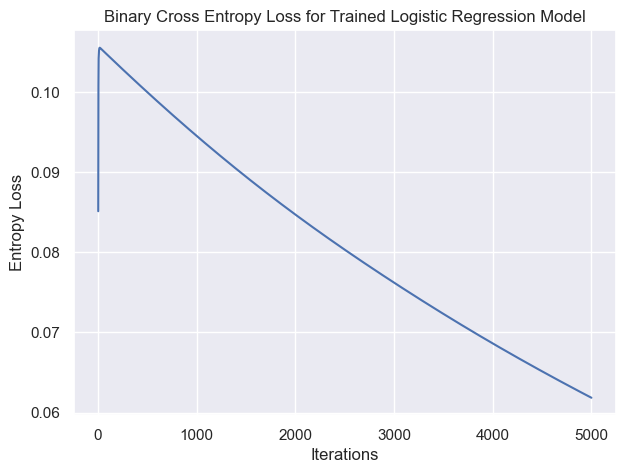

In [20]:
lr_model2.plot_cost_function()
plt.show()

It's interesting that the loss increases at first, but by the 5000th iteration, it has been minimized. There is no sign of plateau'ing yet, so maybe I could've trained it for some more iterations to try and improve the model. But let's look at the performance of this model as is.

In [21]:
# Obtain predictions for training set and find the error of the model
y_train_pred2 = lr_model2.predict(X_train2)
print("Training accuracy:", sum(y_train2 == y_train_pred2) / len(y_train2))

Training accuracy: 0.976123595505618


In [22]:
# Obtain predictions for testing set and find the test accuracy
y_test_pred2 = lr_model2.predict(X_test2)
print("Testing accuracy:", sum(y_test2 == y_test_pred2) / len(y_test2))

Testing accuracy: 0.9888268156424581


In [23]:
print(classification_report(y_test2, y_test_pred2))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        73
           1       0.98      1.00      0.99       106

    accuracy                           0.99       179
   macro avg       0.99      0.99      0.99       179
weighted avg       0.99      0.99      0.99       179



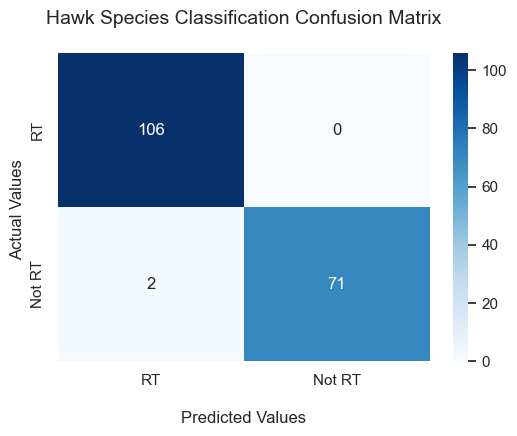

In [24]:
plot_RT_confusion_matrix(y_test2, y_test_pred2)
plt.show()

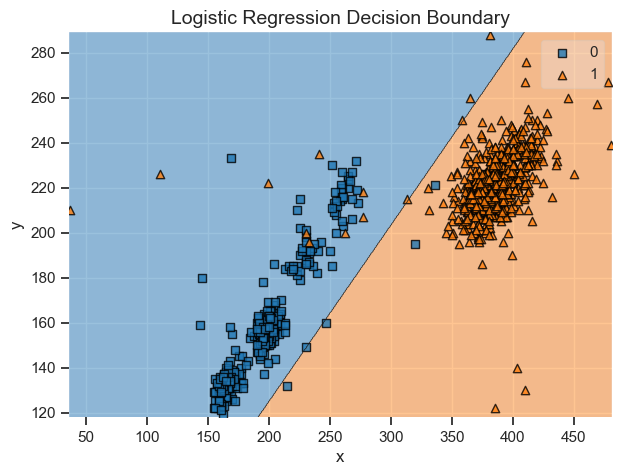

In [25]:
lr_model2.plot_decision_boundary(X2, y)

## Model 3: Binary Classification Using 5 Predictors

In [26]:
X3 = hawks[["Wing", "Tail", "Weight", "Hallux", "Culmen"]].to_numpy()
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.20, random_state=1)

In [27]:
# Train the logistic regression model
lr_model3 = LogisticRegression()
lr_model3.train(X_train3, y_train3, 0.0001, 5000)

/var/folders/vw/11tt08k53x3ftj1j70zwt66c0000gn/T/ipykernel_3503/688124607.py:62: RuntimeWarning: divide by zero encountered in log
  return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)
/var/folders/vw/11tt08k53x3ftj1j70zwt66c0000gn/T/ipykernel_3503/688124607.py:62: RuntimeWarning: invalid value encountered in multiply
  return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)


As a reminder, the "RuntimeWarning: divide by zero encountered in log" error is possible due to a predicted probability being very close to 0 or 1, which causes the logarithm to approach NaN (not a number). The "RuntimeWarning: invalid value encountered in multiply" error occurs for the same reason.

To prevent these errors, I could standardize or normalize the features to a more appropriate range. This doesn't always solve the issue, however. Interpretation wise, it could also change the importance of certain features, which in turn affects the predicted probability.

In [28]:
# Obtain model weights
lr_model3.weights_

array([ 0.30621812, -1.15935959,  0.1771618 ,  0.28908462,  3.94654003,
        0.130663  ])

### Performance/error analysis for model 3

In [29]:
# Obtain predictions for training set and find the error of the model
y_train_pred3 = lr_model3.predict(X_train3)
print("Training accuracy:", sum(y_train3 == y_train_pred3) / len(y_train3))

Training accuracy: 0.9705056179775281


In [30]:
# Obtain predictions for testing set and find the test accuracy
y_test_pred3 = lr_model3.predict(X_test3)
print("Testing accuracy:", sum(y_test3 == y_test_pred3) / len(y_test3))

Testing accuracy: 0.9664804469273743


In [31]:
print(classification_report(y_test3, y_test_pred3))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        73
           1       0.95      1.00      0.97       106

    accuracy                           0.97       179
   macro avg       0.97      0.96      0.96       179
weighted avg       0.97      0.97      0.97       179



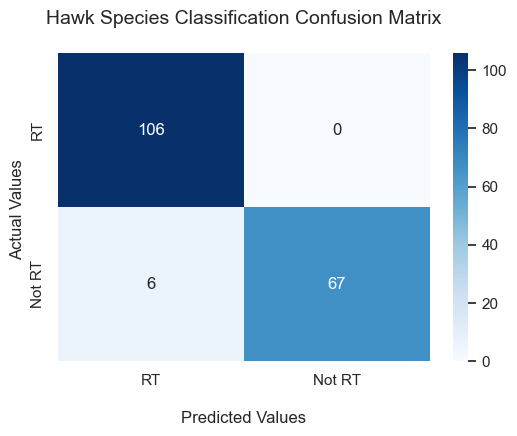

In [32]:
plot_RT_confusion_matrix(y_test3, y_test_pred3)
plt.show()

## Comparing logistic regression models 1-3

## Using scikit-learn

In [33]:
from sklearn.linear_model import LogisticRegression as skLogisticRegression

log_reg = skLogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.intercept_, log_reg.coef_

(array([-19.21080332]), array([[0.09981994]]))

In [34]:
log_reg.score(X_train, y_train)

0.9452247191011236

In [35]:
log_reg.score(X_test, y_test)

0.9385474860335196

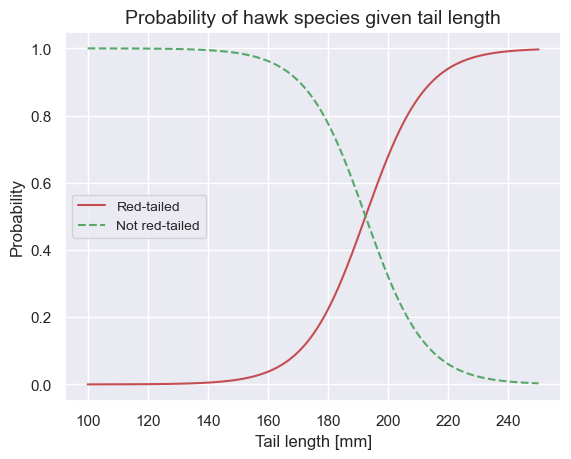

In [36]:
# Plot estimated probabilities to find decision boundary
X_new = np.linspace(100, 250, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "r-", label="Red-tailed") 
plt.plot(X_new, y_proba[:, 0], "g--", label="Not red-tailed")
plt.legend(fontsize = 10, loc = "center left")
plt.xlabel("Tail length [mm]", fontsize = 12)
plt.ylabel("Probability", fontsize = 12)
plt.title("Probability of hawk species given tail length", fontsize = 14)
plt.show()

In [37]:
# Predict a hawk's classification given their tail length is 160 mm
log_reg.predict(np.array([160]).reshape(-1, 1))

array([0])

In [38]:
# Predict a hawk's classification given their tail length is 220 mm
log_reg.predict(np.array([220]).reshape(-1, 1))

array([1])